## Options 
##### 28.02.19

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime,timedelta
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import warnings
from mibian import BS

In [5]:
cboe_options = pd.read_csv('UnderlyingOptionsEODCalcs_2019-02-04.csv', parse_dates = True)
cboe_options['expiration'] = cboe_options['expiration'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) # Экспирация
cboe_options['quote_date'] = cboe_options['quote_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) # текущая дата
xom = pd.read_csv('XOM.csv')
xom['Date'] = xom['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

## Option analysis

In [6]:
date = '2019-02-04'
quote_date = datetime.strptime(date, '%Y-%m-%d')
expiration_date = '2019-02-15'
expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d')
S_0 = float(xom[xom.Date == quote_date]['Close'])
print('The spot price on the settlement date: ', '$', round(S_0, 3), sep='')

The spot price on the settlement date: $74.82


In [8]:
days = (expiration_date-quote_date).days
T = days / 250
div_y = 0.0423 # continuous dividend rate
strikes = np.array(cboe_options[(cboe_options.quote_date == quote_date) & 
                                (cboe_options.underlying_symbol=='XOM') &
                                (cboe_options.expiration==expiration_date)]['strike'].unique())
# strike ATM 
index_ATM = np.argmin(np.abs(strikes-S_0))
strike_range_index = 5
index_min = max(0, index_ATM-strike_range_index)
index_max = min(len(strikes)-1, index_ATM+strike_range_index)
# strike list
strikes_range = strikes[index_min: index_max]

In [9]:
# Option Call
cboe_XOM_call = cboe_options[(cboe_options.quote_date == quote_date) & 
                             (cboe_options.underlying_symbol == 'XOM') & 
                             (cboe_options.option_type == 'C') & 
                             (cboe_options.expiration == expiration_date) & 
                             (cboe_options.strike<=max(strikes_range)) & 
                             (cboe_options.strike >= min(strikes_range))][['strike', 
                                                                           'high',
                                                                           'low',
                                                                           'close',
                                                                           'delta_1545',
                                                                           'gamma_1545',
                                                                           'vega_1545',
                                                                           'implied_volatility_1545']]


In [10]:
# Option Put
cboe_XOM_put = cboe_options[(cboe_options.quote_date == quote_date) &
                            (cboe_options.underlying_symbol == 'XOM') &
                            (cboe_options.option_type == 'P') & 
                            (cboe_options.expiration == expiration_date) &
                            (cboe_options.strike <= max(strikes_range)) & 
                            (cboe_options.strike >= min(strikes_range))][['strike',
                                                                          'high',
                                                                          'low',
                                                                          'close',
                                                                          'delta_1545',
                                                                          'gamma_1545',
                                                                          'vega_1545',
                                                                          'implied_volatility_1545']]

## The CRR model

In [11]:
class CRR:
    def __init__(self,S_0,K,r,T,N,sigma,div=0,t=0,is_call=True,is_european=True):
        self._S_0=S_0
        self._K=K
        self._r=r
        self._div=div
        self._T=T
        self._N=N
        self._sigma=sigma
        self._t=t
        self._is_call=is_call  
        self._is_european=is_european

    def __set_up__(self):
        self._dt=T/N
        self._df=np.exp(-(self._r-self._div)*self._dt)
        self._u=np.exp(self._sigma*np.sqrt(self._dt))
        self._d=1/self._u
        self._p=(np.exp((self._r-self._div)*self._dt)-self._d)/(self._u-self._d)
        self._q=1-self._p
    
    def __path_gen__(self):
            self._S=[np.array([self._S_0])]
            for i in range(self._N):
                prev=self._S[-1]
                st=np.concatenate((prev*self._u,[prev[-1]*self._d]))
                self._S.append(st)
       
    def __initialize_payoffs__(self):
            final_state=self._S[N]
            return np.maximum(0,(final_state-self._K)) if self._is_call else np.maximum(0,(self._K-final_state))
        
    def __check_early_ex__(self,i,payoffs):
            early_payoffs=(self._S[i]-self._K) if self._is_call else (self._K-self._S[i])
            return np.maximum(early_payoffs,payoffs)                                                                
        
    def __traverse_tree__(self,payoffs):                                        
            for i in reversed(range(self._N)):
                payoffs=(payoffs[:-1]*self._p+payoffs[1:]*self._q)*self._df
                #print(payoffs)
                if not self._is_european:
                    payoffs=self.__check_early_ex__(i,payoffs)
            return payoffs 
                       
    def get_price(self):
            self.__set_up__()
            self.__path_gen__()                  
            payoffs_init=self.__initialize_payoffs__()
            payoffs=self.__traverse_tree__(payoffs_init)                 
            return payoffs[0] 
    
    def get_path(self):
        self.__set_up__()
        self.__path_gen__() 
        return self._S
    
    def get_prob(self):
        self.__set_up__()
        return self._p,self._q
    
    def get_param(self):
        self.__set_up__()
        return self._u,self._d

## CRR model result

In [12]:
strikes

array([ 40. ,  45. ,  47.5,  50. ,  55. ,  60. ,  61. ,  62. ,  62.5,
        63. ,  64. ,  65. ,  65.5,  66. ,  66.5,  67. ,  67.5,  68. ,
        68.5,  69. ,  69.5,  70. ,  70.5,  71. ,  71.5,  72. ,  72.5,
        73. ,  73.5,  74. ,  74.5,  75. ,  75.5,  76. ,  76.5,  77. ,
        77.5,  78. ,  78.5,  79. ,  80. ,  81. ,  82. ,  82.5,  83. ,
        84. ,  85. ,  87.5,  90. ,  95. , 100. , 105. , 110. , 115. ])

In [13]:
r = 0.025 # rate
N = 8 # step
sigma = 0.2
print('Option call price', 'Option put price', 'Strike', sep='\t')
for i in range(20, 41):
    K = strikes[i]
    option_call = CRR(S_0, K, r, T, N, sigma, is_call = True, div = div_y, is_european=True) # Call
    option_put = CRR(S_0, K, r, T, N, sigma, is_call = False, div = div_y, is_european=True) # Put
    print(round(option_call.get_price(), 4), round(option_put.get_price(), 4), K, sep='\t\t\t')    

Option call price	Option put price	Strike
5.3161			0.049			69.5
4.8349			0.0682			70.0
4.3536			0.0873			70.5
3.929			0.1631			71.0
3.5056			0.2401			71.5
3.0822			0.317			72.0
2.6588			0.394			72.5
2.3179			0.5534			73.0
2.0069			0.7428			73.5
1.6959			0.9322			74.0
1.3849			1.1216			74.5
1.1232			1.3603			75.0
0.9489			1.6864			75.5
0.7746			2.0125			76.0
0.6004			2.3386			76.5
0.4261			2.6647			77.0
0.3427			3.0818			77.5
0.2749			3.5143			78.0
0.207			3.9468			78.5
0.1391			4.3793			79.0
0.0662			5.3071			80.0


In [15]:
# Look at the binomial tree call option for strike 75

K = 75 
r = 0.025
N = 8 
sigma = 0.2
option_call = CRR(S_0, K, r, T, N, sigma, is_call = True, div = div_y, is_european=True)
S = option_call.get_path()# биномиальное дерево

In [18]:
# The dependence of the option value on the standard deviation of the asset

r = 0.025 
N = 8 
K = 75
sigma_temp = 0.2 
print('Option call price', 'Option put price', 'Sigma', sep='\t')
for i in [.5, .6, .7, .8, .85, .9, .95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.3, 1.4, 1.5]:
    sigma = sigma_temp * i
    option_call = CRR(S_0, K, r, T, N, sigma, is_call = True, div = div_y, is_european=True) # Call
    option_put = CRR(S_0, K, r, T, N, sigma, is_call = False, div = div_y, is_european=True) # Put
    print(round(option_call.get_price(), 4), round(option_put.get_price(), 4), round(sigma, 5), sep='\t\t\t')
    sigma = sigma_temp

Option call price	Option put price	Sigma
0.5168			0.7539			0.1
0.6379			0.875			0.12
0.7591			0.9962			0.14
0.8804			1.1175			0.16
0.9411			1.1782			0.17
1.0018			1.2389			0.18
1.0625			1.2996			0.19
1.1232			1.3603			0.2
1.1839			1.421			0.21
1.2446			1.4817			0.22
1.3053			1.5424			0.23
1.366			1.6031			0.24
1.4874			1.7245			0.26
1.6089			1.846			0.28
1.7303			1.9674			0.3


In [19]:
G = nx.Graph()
for i in range(0, N+1):
        for j in range(1, i+2):
            if i < N:
                G.add_edge((i,j), (i+1,j))
                G.add_edge((i,j), (i+1,j+1))

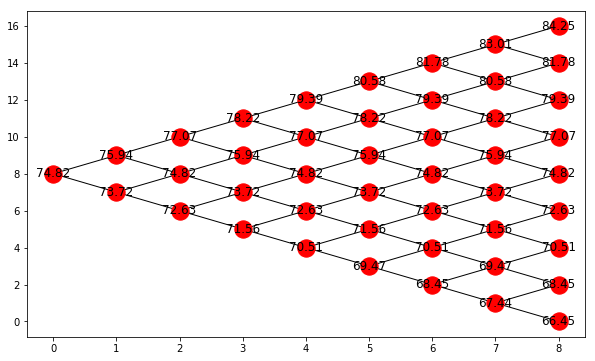

In [20]:
warnings.filterwarnings('ignore')
plt.figure(figsize = (10,6))
posG = {}
labels = {}
i = 0
for node in   G.nodes():
        posG[node] = (node[0], N+2+node[0] - 2 * node[1])
        i,j = node
        labels[node] = round(S[i][j-1], 2)
nx.draw_networkx_nodes(G,posG)
nx.draw_networkx_edges(G,posG)
_ = nx.draw_networkx_labels(G,posG,labels)

In [26]:
print('risk-neutral probabilities', option_call.get_prob())
print('the parameters u and D', option_call.get_param())
option_put = CRR(S_0, K, r, T, N, sigma, is_call = False, div = div_y, is_european=True)
print ('call option Price:$', round(option_call.get_price (), 4), sep='')
print ('put option Price:$', round(option_put.get_price (), 4), sep='')

risk-neutral probabilities (0.49230002145392654, 0.5076999785460734)
the parameters u and D (1.0224979412253854, 0.9779970791937015)
call option Price:$1.7303
put option Price:$1.3603


## Put-call parity

In [27]:
print('Option call: $', round(K * np.exp(-r * (T - 0)) + option_call.get_price(), 4), sep='')
print('Option put: $', round(np.exp(-div_y * (T-0)) * S_0 + option_put.get_price(), 4), sep='')

Option call: $76.6479
Option put: $76.0411


## BSM model (Black Scholes Merton)

In [28]:
class BSM:
        def __init__(self,S_0,K,r,T,sigma,div=0,t=0,is_call=True):
            self._S_0=S_0
            self._K=K
            self._r=r
            self._div=div
            self._T=T
            self._sigma=sigma
            self._t=t
            self._is_call=is_call  
       
        def __d_values__(self):
            self._d1=(np.log(self._S_0/self._K)+(self._r-self._div+0.5*self._sigma**2)*(self._T-self._t))/(self._sigma*np.sqrt(self._T-self._t))
            self._d2=self._d1-self._sigma*np.sqrt(self._T-self._t)
            
        def __N_d__(self,d_value):
            return stats.norm.cdf(d_value)
        
        def __price__(self):
            return (np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(self._d1)-np.exp(-self._r*\
            (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
            else (np.exp(-self._r*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._div*\
            (self._T-self._t))*self._S_0*self.__N_d__(-self._d1))
            
        def get_price(self):
            self.__d_values__()
            price=self.__price__()
            return price
        
        def get_delta(self):
            self.__d_values__()
            return self.__N_d__(self._d1) if self._is_call else  self.__N_d__(self._d1)-1
        
        def get_vega(self):
            self.__d_values__()
            return self._S_0*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)

In [29]:
r = 0.025 
N = 8
sigma = 0.2
print('Option call price', 'Option put price', 'Strike', sep='\t')
for i in range(20, 41):
    K = strikes[i]
    option_call = BSM( S_0, K, r, T, sigma, div=div_y, is_call=True) # Call
    option_put = BSM(S_0, K, r, T, sigma, div = div_y, is_call = False) # Put
    print(round(option_call.get_price(), 4), round(option_put.get_price(), 4), K, sep='\t\t\t')    

Option call price	Option put price	Strike
5.3074			0.0501			69.5
4.8336			0.0757			70.0
4.3701			0.1117			70.5
3.9196			0.1607			71.0
3.4852			0.2257			71.5
3.0701			0.3101			72.0
2.6775			0.4169			72.5
2.3102			0.5491			73.0
1.9709			0.7092			73.5
1.6615			0.8993			74.0
1.3834			1.1206			74.5
1.137			1.3737			75.0
0.9221			1.6582			75.5
0.7375			1.9731			76.0
0.5816			2.3167			76.5
0.4521			2.6866			77.0
0.3463			3.0803			77.5
0.2614			3.4948			78.0
0.1943			3.9272			78.5
0.1423			4.3746			79.0
0.0729			5.3041			80.0


In [30]:
K = 75
r = 0.024
sigma = 0.2
call = True

In [31]:
# Расчет опциона колл
option_call = BSM( S_0, K, r, T, sigma, div=div_y, is_call=True)
print('call option Price: $', round(option_call.get_price(), 4), sep='')
print('call option Delta Value', option_call.get_delta())
print('VEGA call option Value', option_call.get_vega())

call option Price: $1.1355
call option Delta Value 0.4778726383142978
VEGA call option Value 6.251516702521713


In [32]:
# Расчет опциона пут
option_put = BSM(S_0, K, r, T, sigma, div = div_y, is_call = False)
print('put option Price: $', round(option_call.get_price(), 4), sep='')
print('put option Delta Value', option_call.get_delta())
print('VEGA call option Value', option_call.get_vega())

put option Price: $1.1355
put option Delta Value 0.4778726383142978
VEGA call option Value 6.251516702521713


In [33]:
print('Call option; $', round(K * np.exp(-r * (T - 0)) + option_call.get_price(), 4), sep='')
print('Put option: $', round(np.exp(-div_y * (T-0)) * S_0 + option_put.get_price(), 4), sep='')

Call option; $76.0563
Put option: $76.0563


## Option strategies

### Bull spread

In [34]:
sigma = 0.2

In [35]:
bull_spread_setup = pd.DataFrame(zip(['Call', 'Call'], [73,77], 
                                     [CRR(S_0, 74, r, T, N, sigma, is_call = True, div=div_y, is_european=False).get_price(),
                                      CRR(S_0, 75, r, T, N, sigma, is_call = True, div=div_y, is_european=False).get_price()],
                                     ['Buy', 'Sell']), columns=['Type', 'Strike', 'Price', 'Buy/Sell'])

In [36]:
bull_spread_result = pd.DataFrame(zip(range(70, 80), np.maximum(range(70, 80) - bull_spread_setup.iloc[0, 1], 0) - bull_spread_setup.iloc[0, 2],
                                  -np.maximum((range(70, 80) -bull_spread_setup.iloc[1, 1]), 0) + bull_spread_setup.iloc[1, 2]),
                                  columns=['Spot', 'Call1', 'Call2'])

In [37]:
bull_spread_result['Result'] = bull_spread_result['Call1'] + bull_spread_result['Call2']
bull_spread_result

,Spot,Call1,Call2,Result
0,70,-1.70183,1.124386,-0.577444
1,71,-1.70183,1.124386,-0.577444
2,72,-1.70183,1.124386,-0.577444
3,73,-1.70183,1.124386,-0.577444
4,74,-0.70183,1.124386,0.422556
5,75,0.29817,1.124386,1.422556
6,76,1.29817,1.124386,2.422556
7,77,2.29817,1.124386,3.422556
8,78,3.29817,0.124386,3.422556
9,79,4.29817,-0.875614,3.422556


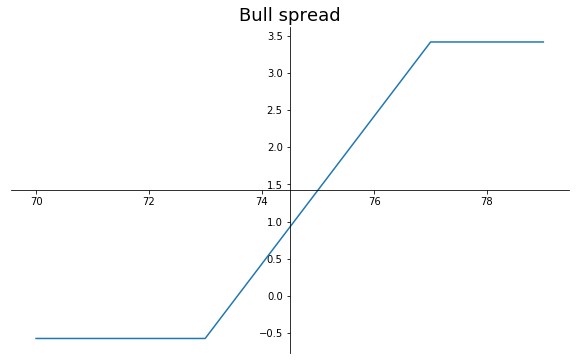

In [38]:
plt.figure(figsize = (10, 6))
plt.plot(bull_spread_result.Spot,bull_spread_result.Result)
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_ticks_position('left')
_=plt.title('Bull spread',fontsize=18)

### Long straddle

In [39]:
long_straddle_setup = pd.DataFrame(zip(['Call', 'Put'],
                                       [75, 75],
                                       [CRR(S_0, 75, r, T, N, sigma, is_call = True, div = div_y, is_european = False).get_price(),
                                        CRR(S_0, 75, r, T, N, sigma, is_call = False, div = div_y, is_european = False).get_price()],
                                       ['Buy', 'Buy']),
                                       columns=['Type', 'Strike', 'Price', 'Buy/Sell'])

In [40]:
long_straddle_result = pd.DataFrame(zip(range(73, 77), 
                                        np.maximum(range(73, 77) - long_straddle_setup.iloc[0, 1], 0)
                                        -long_straddle_setup.iloc[0, 2],
                                        np.maximum(long_straddle_setup.iloc[1, 1] - (range(73, 77)), 0)
                                        -long_straddle_setup.iloc[1, 2]),
                                        columns=['Spot','Call','Put'])

In [41]:
long_straddle_result['Result'] = long_straddle_result['Call'] + long_straddle_result['Put']

In [42]:
long_straddle_result

,Spot,Call,Put,Result
0,73,-1.124386,0.637963,-0.486424
1,74,-1.124386,-0.362037,-1.486424
2,75,-1.124386,-1.362037,-2.486424
3,76,-0.124386,-1.362037,-1.486424


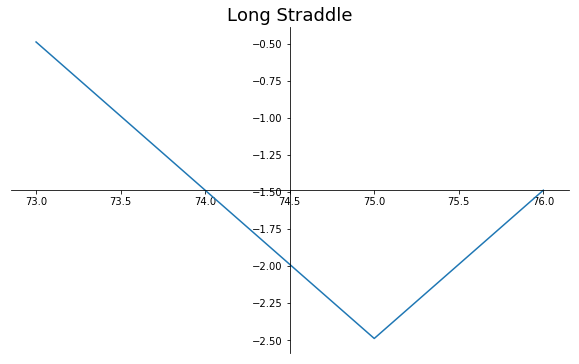

In [43]:
fig=plt.figure(figsize=(10,6))
plt.plot(long_straddle_result.Spot,long_straddle_result.Result)
ax=plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
_=plt.title('Long Straddle',fontsize=18)

## Comparison of theoretical and market prices

In [44]:
N=100 # modell CRR step

# Call

In [45]:
cboe_XOM_call['American_div_Bin'] = cboe_XOM_call.apply(lambda row: np.round(
    CRR(S_0, row['strike'], r, T, N, row['vega_1545'], 
        is_call=True, div=div_y, 
        is_european = False).get_price(), 2), axis = 1)
cboe_XOM_call['European_div_Bin'] = cboe_XOM_call.apply(lambda row: np.round(
    CRR(S_0, row['strike'], r, T, N, row['vega_1545'], 
        is_call = True, div = div_y, 
        is_european = True).get_price(), 2), axis = 1)
cboe_XOM_call['BSM_div'] = cboe_XOM_call.apply(
    lambda row: np.round(BSM(S_0, row['strike'], r, T, row['vega_1545'],
                             is_call = True).get_price(), 2), axis = 1)

## Put

In [46]:
cboe_XOM_put['American_div_Bin'] = cboe_XOM_put.apply(
    lambda row: np.round(
        CRR(S_0, row['strike'], r, T, N, row['vega_1545'], is_call = False, div=div_y,is_european=False)
        .get_price(), 2), axis = 1)
cboe_XOM_put['European_div_Bin'] = cboe_XOM_put.apply(
    lambda row: np.round(
        CRR(S_0,row['strike'], r, T, N, row['vega_1545'], is_call = False, div = div_y, is_european = True)
        .get_price(), 2), axis = 1)
cboe_XOM_put['BSM_div'] = cboe_XOM_put['BSM_div'] = cboe_XOM_put.apply(
    lambda row: np.round(BSM(S_0, row['strike'], r, T, row['vega_1545'], 
                             is_call = False).get_price(), 2), axis = 1)

In [47]:
cboe_XOM_call.head(10)

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
2640,72.5,2.91,2.10,2.36,0.7241,0.1100,0.0426,0.2294,2.32,2.26,2.40
2642,73.0,2.15,1.80,1.80,0.6797,0.1305,0.0458,0.2076,1.82,1.76,1.90
2644,73.5,1.71,1.28,1.44,0.6165,0.1484,0.0490,0.1955,1.32,1.28,1.41
2646,74.0,1.58,0.97,1.10,0.5410,0.1630,0.0511,0.1856,0.85,0.83,0.95
2648,74.5,1.53,0.68,0.81,0.4557,0.1724,0.0512,0.1756,0.47,0.47,0.56
2650,75.0,1.27,0.48,0.58,0.3664,0.1698,0.0487,0.1696,0.20,0.20,0.26
2652,75.5,0.71,0.32,0.36,0.2807,0.1562,0.0436,0.1653,0.05,0.05,0.07
2654,76.0,0.65,0.22,0.24,0.2054,0.1340,0.0369,0.1628,0.00,0.00,0.01
2656,76.5,0.60,0.15,0.15,0.1453,0.1079,0.0296,0.1623,0.00,0.00,0.00
2658,77.0,0.17,0.10,0.10,0.0992,0.0824,0.0226,0.1624,0.00,0.00,0.00


In [48]:
cboe_XOM_put.head(10)

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
2641,72.5,0.56,0.27,0.40,-0.2478,0.1171,0.0410,0.2069,0.00,0.00,0.00
2643,73.0,0.66,0.53,0.53,-0.3088,0.1327,0.0456,0.2033,0.00,0.00,0.00
2645,73.5,0.91,0.72,0.72,-0.3785,0.1445,0.0492,0.2013,0.02,0.02,0.01
2647,74.0,1.15,0.88,0.90,-0.4532,0.1512,0.0511,0.2001,0.07,0.07,0.05
2649,74.5,1.39,1.16,1.19,-0.5295,0.1508,0.0513,0.2012,0.21,0.21,0.16
2651,75.0,1.75,1.36,1.45,-0.6029,0.1446,0.0496,0.2027,0.45,0.45,0.36
2653,75.5,2.11,1.49,1.90,-0.6685,0.1325,0.0465,0.2075,0.80,0.80,0.69
2655,76.0,2.40,2.18,2.29,-0.7258,0.1184,0.0425,0.2124,1.25,1.25,1.11
2657,76.5,0.00,0.00,0.00,-0.7664,0.1021,0.0389,0.2254,1.74,1.74,1.60
2659,77.0,3.30,2.80,3.30,-0.7958,0.0878,0.0359,0.2416,2.24,2.24,2.10


## Sensitivity index Δ
#### Delta - hedging. Calculation of indicators s Δ is given in the lecture materials.
### $C=\Delta S-B$
### $P=\Delta S+B$
#### At each step we rebalancer portfolio taking into account equality:
### $dP=\Delta dS$ (for a call option the calculation is the same)
#### Rebalancing takes into account interest on a cash position
##### In this task we will model the dynamics of the asset using geometric Brownian motion
### $S_{i+1}=S_i exp((r-0.5\sigma^2)\Delta_t+\sigma\sqrt{\Delta_t}Z_t)$

In [49]:
def GBM(n_step,S_0,r,sigma,dt):
    S=np.zeros(n_step)
    S[0]=S_0
    rand=np.random.standard_normal(n_step)
    for i in range(1,n_step):
        S[i]=S[i-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*rand[i])
    return S    

## We implement a step-by-step process of option replication (creating a portfolio that reproduces the option price)

In [50]:
r = 0.0024
T = 30/250
sigma=sigma = 0.2 
n_step = int(T*250)
dt = 1/250
S = np.zeros(n_step) 
Delta = np.zeros(n_step)
Option_theor = np.zeros(n_step)
S_Delta = np.zeros(n_step)
Bond = np.zeros(n_step)
Replicate = np.zeros(n_step)

### The calculation of the initial values of the parameters

In [51]:
S[0] = S_0
option=BSM(S_0,K,r,T,sigma,t=0,is_call=True)
Option_theor[0] = option.get_price()
Replicate[0] = Option_theor[0]
print('Theoretical price: $', round(Option_theor[0], 4), sep='')
Delta[0] = option.get_delta()
S_Delta[0] = S[0]*Delta[0]
print('Delta: ', round(Delta[0], 4), sep='')
Bond[0] = Option_theor[0]-S_Delta[0]
print('Hedge ', round(Bond[0], 4), sep='')
S = GBM(n_step, S_0, r, sigma, dt)

Theoretical price: $1.9915
Delta: 0.5016
Hedge -35.5413


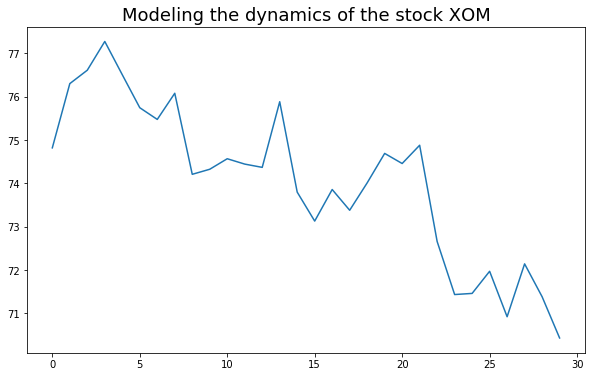

In [52]:
plt.figure(figsize=(10,6))
_=plt.plot(S)
_=plt.title(u'Modeling the dynamics of the stock XOM',fontsize=18)

## Step-by-step replication

In [53]:
for i in range(1,n_step):
    option=BSM(S[i],K,r,T,sigma,is_call=False,t=i/250)
    Option_theor[i]=option.get_price()
    Delta[i]=option.get_delta()
    S_Delta[i]=S[i]*Delta[i]
    Replicate[i]=Replicate[i-1]+(S[i]-S[i-1])*Delta[i-1]+Bond[i-1]*(np.exp(r/250)-1)
    Bond[i]=Option_theor[i]-S_Delta[i]

In [54]:
pd.DataFrame(zip(S, Option_theor, Replicate, Delta, S_Delta, Bond),
             columns = ['S', 'Theor_price', 'Replicate', 'Delta', 'Delta*Price', 'Bond']).head()

,S,Theor_price,Replicate,Delta,Delta*Price,Bond
0,74.820000,1.991527,1.991527,0.501642,37.532836,-35.541309
1,76.303027,1.460640,2.735134,-0.385522,-29.416480,30.877120
2,76.613082,1.310872,2.615898,-0.361142,-27.668166,28.979039
3,77.276413,1.054308,2.376619,-0.311455,-24.068106,25.122414
4,76.508375,1.279508,2.616070,-0.365106,-27.933686,29.213194


## VEGA sensitivity indicator
#### Calculation of vega index is given in lecture materials

In [55]:
prices_market = np.array((cboe_XOM_call.high + cboe_XOM_call.low) / 2)

### Finding the optimal value of the IV Newton-Raphson method
### $\sigma_{i+1}=\sigma_{i}-\frac{c(\sigma_{i})-c_m}{Vega}$
### For the correct implementation of the algorithm it is necessary that the market value is not less than the internal value

In [56]:
# Newton-Raphson
T = days / 250
sigma_list = []
tol = 0.001
for  strike, price in zip(strikes_range, prices_market):
    if (strike+price) > S_0:
        sigma = 0.3
        diff = 1000
        while (diff > tol):
            option = BSM(S_0, strike, r, T, sigma, div=div_y)
            Price_theor = option.get_price()
            Vega = option.get_vega()
            sigma_prev = sigma
            sigma = sigma_prev-(Price_theor-price) / Vega
            diff = abs(price-Price_theor) 
        sigma_list.append((sigma, strike,Vega))     

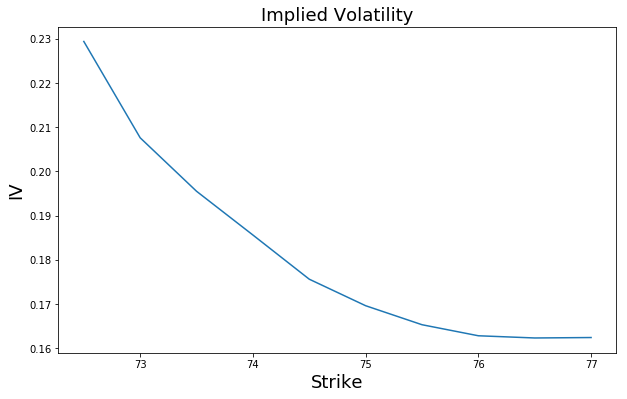

In [57]:
plt.figure(figsize=(10,6))
_=plt.plot(cboe_XOM_call.strike, cboe_XOM_call.implied_volatility_1545)
_=plt.xlabel('Strike', fontsize=18)
_=plt.ylabel('IV', fontsize=18)
_=plt.title('Implied Volatility',fontsize=18)

## Summary
#### The calculation shows that there is parity between the put and call options, while the option price itself is highly dependent on the standard deviation and the difference between the strike and the spot price.
#### Option strategies are mainly related to the volatility of an asset. Therefore, buying or selling an option can be understood as buying and selling volatility